In [1]:
#! git clone https://github.com/pytorch/vision
#! pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI
#install cython first with python -m pip install --upgrade cython
#! pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html --user
#! pip install pandas
#! pip install matplotlib
#! pip install tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import numpy as np
from PIL import Image
import torch
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
torch.cuda.is_available()
np.random.seed(10)

In [2]:
annotation = np.genfromtxt('annot_train_updated.csv', delimiter=',', dtype=str)[1:]
annotation

array([['0', 'charlotte_1019088214340003257_20150630.jpg', '640', ...,
        '381', '439', '0'],
       ['1', 'charlotte_1056018576661922536_20150820.jpg', '640', ...,
        '574', '30', '1'],
       ['2', 'charlotte_1057610050380125945_20150823.jpg', '1080', ...,
        '473', '477', '2'],
       ...,
       ['46045', 'phoenix_908134630674502361_20150128.jpg', '640', ...,
        '120', '251', '38910'],
       ['46046', 'phoenix_910188468778720739_20150131.jpg', '640', ...,
        '394', '319', '38911'],
       ['46047', 'phoenix_911590231898221794_20150202.jpg', '640', ...,
        '495', '168', '38912']], dtype='<U42')

In [3]:
unique, counts = np.unique(annotation[:, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['1' '954']
 ['10' '754']
 ['11' '8119']
 ['12' '623']
 ['13' '724']
 ['14' '2374']
 ['15' '858']
 ['16' '1467']
 ['17' '918']
 ['2' '964']
 ['3' '1131']
 ['4' '9566']
 ['5' '2079']
 ['6' '2089']
 ['7' '1859']
 ['8' '774']
 ['9' '3660']]


In [4]:
print(len(annotation))
annotation = annotation[np.isin(annotation[:, 4], ['3', '15', '9', '5', '13'])]
print(len(annotation))

38913
8452


In [5]:
#from sklearn.model_selection import train_test_split

In [6]:
#x_train, x_test = train_test_split(annotation, test_size=0.3)

In [7]:
unique, counts = np.unique(annotation[:5000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['15' '858']
 ['5' '482']
 ['9' '3660']]


In [8]:
annotation[:, 4][np.where(annotation[:, 4] == '13')] = '1'
annotation[:, 4][np.where(annotation[:, 4] == '15')] = '2'
annotation[:, 4][np.where(annotation[:, 4] == '3')] = '3'
annotation[:, 4][np.where(annotation[:, 4] == '5')] = '4'
annotation[:, 4][np.where(annotation[:, 4] == '9')] = '5'

In [9]:
np.random.shuffle(annotation)

In [10]:
unique, counts = np.unique(annotation[:5000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['1' '420']
 ['2' '520']
 ['3' '682']
 ['4' '1227']
 ['5' '2151']]


In [11]:
unique, counts = np.unique(annotation[5000:7000, 4], return_counts=True)

print(np.asarray((unique, counts)).T)

[['1' '179']
 ['2' '203']
 ['3' '248']
 ['4' '475']
 ['5' '895']]


In [12]:
annotation[:, 5] = annotation[:, 5].astype(int) / annotation[:, 2].astype(int)
annotation[:, 7] = annotation[:, 7].astype(int) / annotation[:, 2].astype(int)
annotation[:, 6] = annotation[:, 6].astype(int) / annotation[:, 3].astype(int)
annotation[:, 8] = annotation[:, 8].astype(int) / annotation[:, 3].astype(int)


In [13]:
annotation[:, 5:9]

array([['0.8953703703703704', '0.1527777777777778', '0.9935185185185185',
        '0.28888888888888886'],
       ['0.712037037037037', '0.28317272053372866', '0.7731481481481481',
        '0.3424759080800593'],
       ['0.9', '0.809076682316119', '0.9805555555555555',
        '0.8935837245696401'],
       ...,
       ['0.05466666666666667', '0.5266666666666666',
        '0.3373333333333333', '0.7813333333333333'],
       ['0.5', '0.0', '0.6898148148148148', '0.057777777777777775'],
       ['0.025', '0.5694716242661448', '0.24259259259259258',
        '0.8542074363992173']], dtype='<U42')

In [14]:
class DLCVDataset(torch.utils.data.Dataset):
    def __init__(self, annotation, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = annotation[:, 1]
        self.annotation = annotation
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join("train", self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        ##mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        ##mask = np.array(mask)
        # instances are encoded as different colors
        ##obj_ids = np.unique(mask)
        # first id is the background, so remove it
        ##obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        ##masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        ##num_objs = len(obj_ids), dtype=torch.int16
        ##boxes = []
        ##for i in range(num_objs):
        ##    pos = np.where(masks[i])
        ##    xmin = np.min(pos[1])
        ##    xmax = np.max(pos[1])
        ##    ymin = np.min(pos[0])
        ##    ymax = np.max(pos[0])
        ##    boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(self.annotation[idx, 5:9].astype(float).reshape(1, -1), dtype=torch.float64)

        labels = torch.tensor([int(self.annotation[idx, 4])], dtype=torch.int64)


        ##masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [17]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')


# our dataset has two classes only - background and person
num_classes = 6
# use our dataset and defined transformations
i, f = 1000, 1200
dataset = DLCVDataset(annotation=annotation[:i], transforms=get_transform(train=True))
dataset_test = DLCVDataset(annotation=annotation[i:f], transforms=get_transform(train=False))

print(len(dataset))
print(len(dataset_test))

1000
200


In [18]:

# split the dataset in train and test set

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)



In [19]:


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00005,
                            momentum=0.95, weight_decay=0.000005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device)

print("That's it!")

/home/3040302/.conda/envs/vision2021/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/1000]  eta: 0:14:39  lr: 0.000000  loss: 4.8121 (4.8121)  loss_classifier: 2.0165 (2.0165)  loss_box_reg: 0.0033 (0.0033)  loss_objectness: 1.3110 (1.3110)  loss_rpn_box_reg: 1.4813 (1.4813)  time: 0.8798  data: 0.3514  max mem: 0
Epoch: [0]  [ 999/1000]  eta: 0:00:00  lr: 0.000050  loss: 0.1943 (0.9373)  loss_classifier: 0.0122 (0.2240)  loss_box_reg: 0.0004 (0.0013)  loss_objectness: 0.0051 (0.1942)  loss_rpn_box_reg: 0.1562 (0.5177)  time: 0.1651  data: 0.0084  max mem: 0
creating index...
index created!
Test:  [  0/200]  eta: 0:01:32  model_time: 0.0670 (0.0670)  evaluator_time: 0.0024 (0.0024)  time: 0.4608  data: 0.3778  max mem: 0
Test:  [100/200]  eta: 0:00:07  model_time: 0.0532 (0.0542)  evaluator_time: 0.0006 (0.0008)  time: 0.0695  data: 0.0050  max mem: 0
Test:  [199/200]  eta: 0:00:00  model_time: 0.0540 (0.0543)  evaluator_time: 0.0005 (0.0008)  time: 0.0694  data: 0.0053  max mem: 0
Averaged stats: model_time: 0.0540 (0.0543)  evaluator_time: 0.0005 (0

target 2
boxes ['470' '1032' '736' '1122']


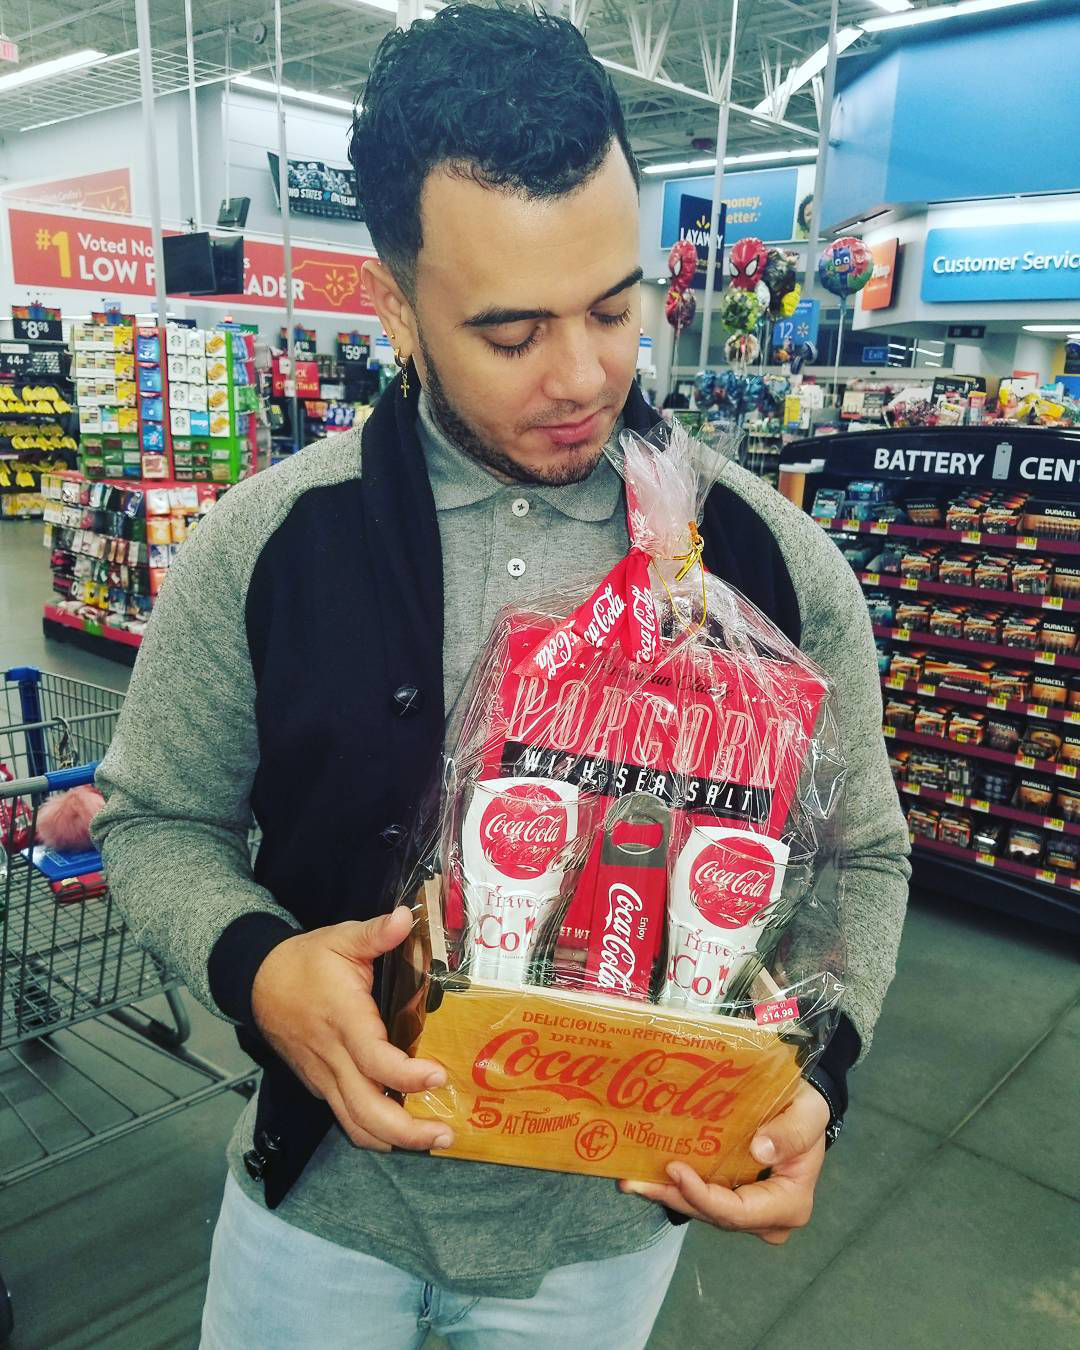

In [133]:
num = 5010
img_path = os.path.join("train", annotation[num][1])
#mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
img = Image.open(img_path).convert("RGB")
print('target', annotation[num, 4])
print('boxes', annotation[num][5:9])
img

In [134]:
# pick one image from the test set
img, _ = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to('cpu')])
    
prediction[0]

{'boxes': tensor([[  21.1634,  776.8896,  101.6154,  856.3831],
         [ 887.8901,  346.9011,  908.7220,  363.8595],
         [ 865.9109,  345.8053,  893.7623,  363.5903],
         [ 333.2028,  771.8491,  436.2597, 1052.6586],
         [ 424.1701,  669.1344,  643.7623, 1110.4377],
         [ 822.0300,  236.9328,  861.7619,  303.2376],
         [ 252.8672, 1062.0391,  333.1206, 1199.5183],
         [  34.2695,  795.5261,   84.6325,  848.5409],
         [ 375.5155,  935.1522,  433.4576, 1012.0579],
         [ 741.4457,  244.9660,  800.3897,  319.7540],
         [  31.8131,  818.9272,  101.8359,  895.4230],
         [  76.2328,  580.4299,  101.5335,  605.5570],
         [ 722.1967,  246.2009,  780.8817,  323.5978],
         [ 346.9026,  677.9308,  454.8055,  960.8369],
         [ 364.6725,  897.5674,  427.9630, 1020.0770],
         [ 621.8721,  390.3376,  662.9444,  436.5311],
         [  29.6233,  848.9912,  104.8389,  884.2318],
         [  71.4247,  385.5149,  138.0768,  405.0663],
 

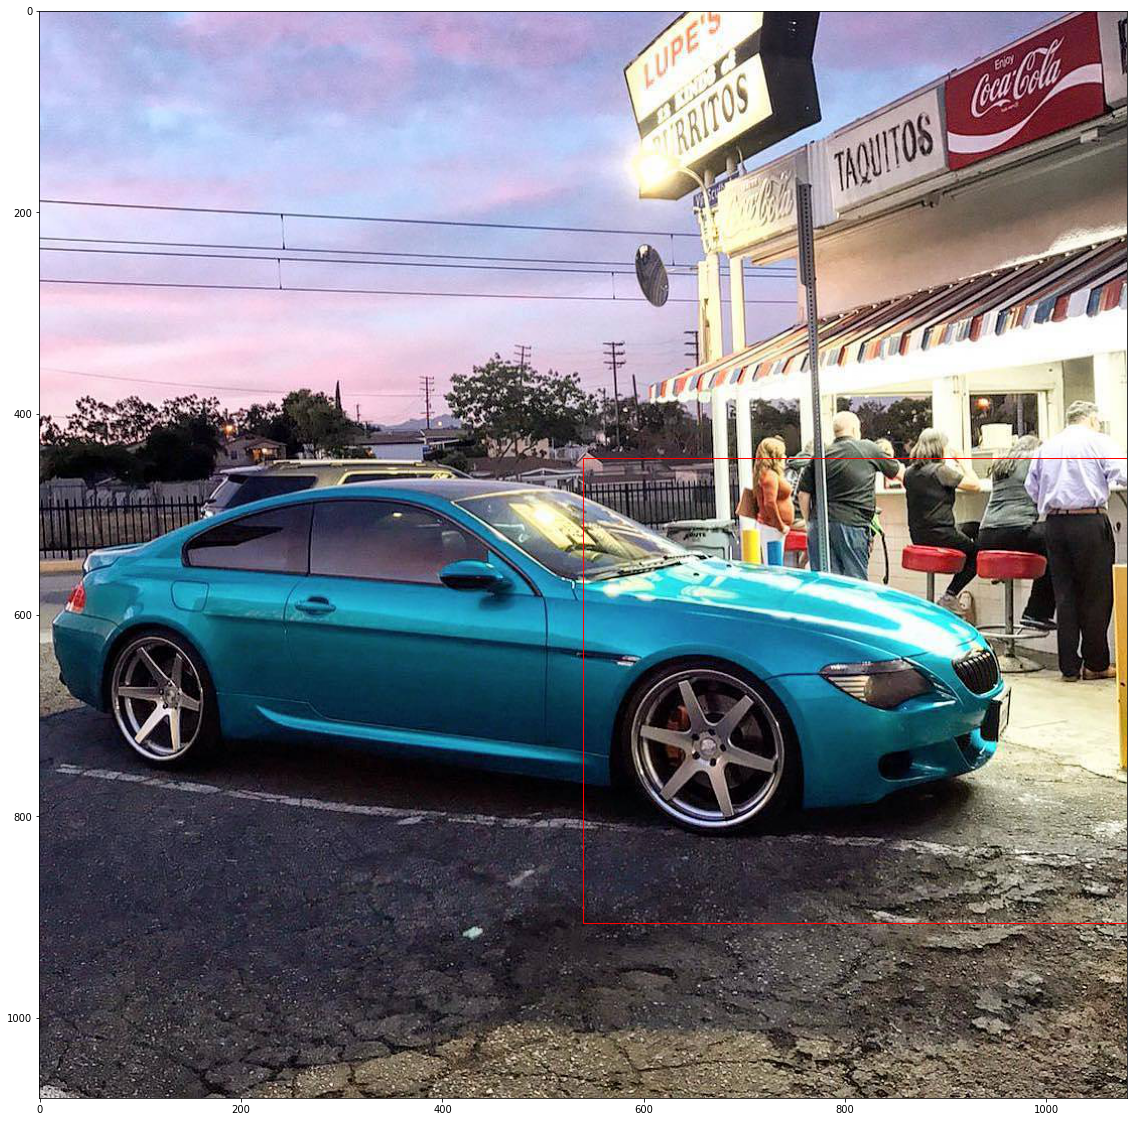

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
plt.imshow(img.permute(1, 2, 0))
plt.gca().add_patch(Rectangle((540,444),558, 462, linewidth=1,edgecolor='r',facecolor='none'))

### Save a model to avoid training

In [17]:
#torch.save(model.state_dict(), 'model_1')

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 5  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
model.load_state_dict(torch.load('model_1'))

<All keys matched successfully>

In [20]:
num_classes = 5
# use our dataset and defined transformations
i, f = 5000, 7000
dataset = DLCVDataset(annotation=annotation[:i], transforms=get_transform(train=True))
dataset_test = DLCVDataset(annotation=annotation[i:f], transforms=get_transform(train=False))

# split the dataset in train and test set

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


In [21]:
evaluate(model, data_loader_test, device)


creating index...
index created!
hello


/home/3040302/.conda/envs/vision2021/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Test:  [   0/2000]  eta: 0:27:41  model_time: 0.4061 (0.4061)  evaluator_time: 0.0059 (0.0059)  time: 0.8305  data: 0.3908  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
Test:  [ 100/2000]  eta: 0:02:07  model_time: 0.0390 (0.0456)  evaluator_time: 0.0018 (0.0026)  time: 0.0588  data: 0.0059  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hell

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
Test:  [1200/2000]  eta: 0:00:47  model_time: 0.0398 (0.0422)  evaluator_time: 0.0022 (0.0026)  time: 0.0575  data: 0.0052  max mem: 0
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
h